# Compound Binds Gene Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
total_candidates_df = (
    pd
    .read_table("../dataset_statistics/data/all_cbg_candidates.tsv.xz")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
817507,3630,INS,DB01124,Tolbutamide,NaN,0,621,1,0.42709,6,1.0,0.0,1.0,613126,Plasma insulin response to intravenous tolbuta...,12,50493
1864368,2520,GAST,DB00183,Pentagastrin,NaN,0,137,1,0.84974,7,1.0,0.0,1.0,486392,The effect of magnesium on calcium- and pentag...,22,50494


In [3]:
sentence_prediction_df = (
    pd
    .read_table("results/all_predicted_sentences.tsv")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,model_prediction
0,50493,0.517963
1,50494,0.367304


In [4]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "drugbank_id", "name", 
    "entrez_gene_id", "gene_symbol", 
    "text", "hetionet",
    "candidate_id"
    ]]
    .rename(index=str, columns={"name": "drug_name"})
    .merge(sentence_prediction_df, on="candidate_id")
)
total_candidates_pred_df.to_csv(
    "results/combined_predicted_cbg_sentences.tsv.xz", 
    sep="\t", index=False, compression="xz"
)
total_candidates_pred_df.head(2)

,drugbank_id,drug_name,entrez_gene_id,gene_symbol,text,hetionet,candidate_id,model_prediction
0,DB01124,Tolbutamide,3630,INS,Plasma insulin response to intravenous tolbuta...,0,50493,0.517963
1,DB00183,Pentagastrin,2520,GAST,The effect of magnesium on calcium- and pentag...,0,50494,0.367304


In [5]:
# DataFrame that groups compound and gene mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["drugbank_id", "entrez_gene_id"], as_index=False)
    .agg({
        "model_prediction": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "gene_symbol": 'first',
        "drug_name": 'first'
    })
)
grouped_candidates_pred_df.head(2)

drugbank_id entrez_gene_id model_prediction                     hetionet  \
                                          max      mean    median      max   
0     DB00001            462         0.394295  0.394295  0.394295        0   
1     DB00001           2147         0.627754  0.499056  0.537586        1   

  gene_symbol  drug_name  
        first      first  
0    SERPINC1  Lepirudin  
1          F2  Lepirudin

In [6]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'drug_name'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]
grouped_candidates_pred_df.head(2)

,drugbank_id,entrez_gene_id,model_prediction_max,model_prediction_mean,model_prediction_median,hetionet,gene_symbol,drug_name
0,DB00001,462,0.394295,0.394295,0.394295,0,SERPINC1,Lepirudin
1,DB00001,2147,0.627754,0.499056,0.537586,1,F2,Lepirudin


In [7]:
grouped_candidates_pred_df.hetionet.value_counts()

0    229810
1      5496
Name: hetionet, dtype: int64

In [8]:
performance_map = {}

In [9]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

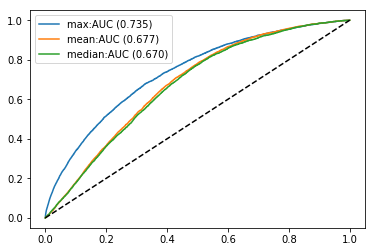

In [12]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

In [13]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = pd.np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
roc_optimal = Find_Optimal_Cutoff(grouped_candidates_pred_df.hetionet.values, grouped_candidates_pred_df.model_prediction_max)[0]
roc_optimal

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.5040749

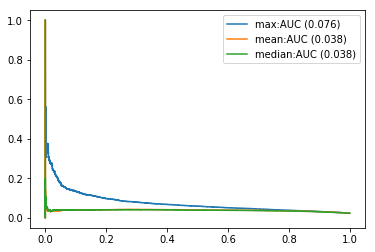

In [14]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimal PR-Cutoff

In [15]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
231123,0.666667,0.000364,0.864714
231110,0.562500,0.001638,0.833758


In [16]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.query("precision > 0").precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in tqdm_notebook(precision_thresholds):

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_df
        .query("model_prediction_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

HBox(children=(IntProgress(value=0, max=52), HTML(value='')))

,edges,in_hetionet,precision,sen_cutoff
0,9,Existing,0.56,0.833758
1,7,Novel,0.56,0.833758
2,9,Existing,0.55,0.833758
3,7,Novel,0.55,0.833758
4,9,Existing,0.54,0.833758
5,7,Novel,0.54,0.833758
6,9,Existing,0.53,0.833758
7,7,Novel,0.53,0.833758
8,9,Existing,0.50,0.833205
9,9,Novel,0.50,0.833205


[None]

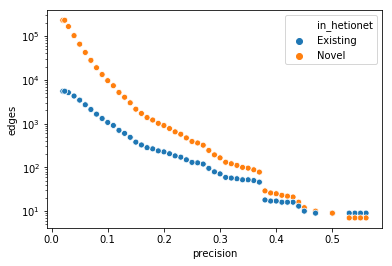

In [17]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df)
ax.set(yscale="log")

In [18]:
edges_added_df.to_csv("results/precision_cbg_edges_added.tsv", index=False, sep="\t")

# Optimal ROC Cutoff

In [19]:
(
    grouped_candidates_pred_df
    .query("model_prediction_max > @roc_optimal")
    .sort_values("hetionet")
    .hetionet.value_counts()
)

0    74727
1     3708
Name: hetionet, dtype: int64

In [20]:
(
    grouped_candidates_pred_df
    .query("model_prediction_max > @roc_optimal")
    .sort_values(["hetionet", "model_prediction_max"], ascending=[True, False])
    .head(10)
)

,drugbank_id,entrez_gene_id,model_prediction_max,model_prediction_mean,model_prediction_median,hetionet,gene_symbol,drug_name
229636,DB07447,2099,0.889551,0.527927,0.490368,0,ESR1,5-beta-DIHYDROTESTOSTERONE
24619,DB00197,6256,0.857222,0.492378,0.483710,0,RXRA,Troglitazone
205951,DB03929,3643,0.855602,0.648784,0.654349,0,INSR,D-Serine
70226,DB00640,1956,0.854739,0.593269,0.597648,0,EGFR,Adenosine
199387,DB03839,3643,0.850353,0.625341,0.632638,0,INSR,D-Tyrosine
199869,DB03839,5295,0.841534,0.554450,0.543068,0,PIK3R1,D-Tyrosine
111737,DB00945,5028,0.839836,0.506656,0.517761,0,P2RY1,Acetylsalicylic acid
205272,DB03929,1387,0.833622,0.492693,0.468308,0,CREBBP,D-Serine
207392,DB03929,8945,0.833205,0.536116,0.556211,0,BTRC,D-Serine
175211,DB02527,3482,0.832981,0.616081,0.616081,0,IGF2R,Cyclic Adenosine Monophosphate
